In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def graphToData(file):
    #data.x: Node feature matrix with shape [num_nodes, num_node_features]
    #data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
    #data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
    #data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
    #data.pos: Node position matrix with shape [num_nodes, num_dimensions]

    graph = np.load(file)
    label = torch.tensor(graph["label"], dtype=torch.float) #shape=[1, 4]
    node_values = torch.tensor(graph["nodes"], dtype=torch.float) #shape=[num_nodes, 1]
    edge_values = torch.tensor(graph["edges"], dtype=torch.float) #shape=[num_edges, 2]
    adj_list = torch.tensor(graph["adj_list"], dtype=torch.long) #shape=[num_edges, 2] <- needs to be reshaped (see pyg doc)
    positions = torch.tensor(graph["positions"], dtype=torch.float) #shape=[num_nodes, 2]
    
    return Data(x=node_values, edge_index=adj_list.t().contiguous(), edge_attr=edge_values, y=label, pos=positions)

def loadData(num_graphs):

    graphs = list()
    print("load squares")
    for i in tqdm(range(num_graphs)):
        file = f"../GenData/square/square_{i}.npz"
        graphs.append(graphToData(file))
    
    print("load rectangles")
    for i in tqdm(range(num_graphs)):
        file = f"../GenData/rectangular/rectangular_{i}.npz"
        graphs.append(graphToData(file))
    
    print("load hexagons")
    for i in tqdm(range(num_graphs)):
        file = f"../GenData/hexagonal/hexagonal_{i}.npz"
        graphs.append(graphToData(file))
    
    print("load oblique")
    for i in tqdm(range(num_graphs)):
        file = f"../GenData/oblique/oblique_{i}.npz"
        graphs.append(graphToData(file))

    return graphs

In [4]:
class TestLayer(torch_geometric.nn.MessagePassing):
    def __init__(self, num_node_features_in, num_node_features_out, num_edge_features_, size_nn_message_hidden, size_nn_update_hidden):
        super().__init__(aggr="add", flow="source_to_target") #source_to_target: create message to node i if (j,i) is edge
        self.num_node_features_in = num_node_features_in
        self.num_node_features_out = num_node_features_out
        self.num_edge_features = num_edge_features_
        self.nn_message = torch.nn.Sequential(
            torch.nn.Linear(in_features=2*self.num_node_features_in + self.num_edge_features, out_features=size_nn_message_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_message_hidden, size_nn_message_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_message_hidden, out_features=num_node_features_out, bias=True)
        )

        self.nn_update = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.num_node_features_out + self.num_node_features_in, out_features=size_nn_update_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_update_hidden, size_nn_update_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_update_hidden, out_features=num_node_features_out, bias=True)
        )

    def forward(self, x, edge_list, edge_attr):
        #x, edge_list, edge_attr = data.x, data.edge_index, data.edge_attr
        #print("data: ", data)
        #print("x", x)
        #print(edge_list)
        out = self.propagate(edge_list, x=x, edge_attr=edge_attr) #calls message(), aggregate(), update()
        #print("out", out)
        return out #shape = [number of nodes, number of node features]

    def message(self, x_i, x_j, edge_attr):
        # _i = central node, _j = neighboring node
        # x_i,j =[number of edges, number of node features]
        # edge_attr = [number of edges, number of edge features]
        # the node with node features x_i[k, :] is connected with the nodes having the features x_j[k, :]. The edge connecting these nodes has the features edge_attr[k,:]
        #print("message")
        #print("x_i: ", x_i)
        #print("x_j: ", x_j)
        #print("edge_attr: ", edge_attr)
        #print(edge_attr)
        vec_in = torch.cat((x_i, x_j, edge_attr), dim = 1) # shape = [num_edges, 2*number of node_features + number of edge_features]
        #print(vec_in.shape)
        message = self.nn_message(vec_in) #shape = [num_edges, num node features]
        #print(message.shape)
        return message #return the message that is passed to node x_i

    def update(self, input, x):
        #input = output from aggregation step -> input shape = [number of nodes, number of node features]
        #x_i shape = [number of nodes, number of node_features]
        #print("input: ", input)
        #print(x.shape, input.shape)
        vec_in = torch.cat((x, input), dim = 1) #shape = [number of nodes, 2* number of node features]
        #print(vec_in.shape)
        updated_input = self.nn_update(vec_in) #shape = [number of nodes, number of node features]
        #print(updated_input.shape)
        return updated_input #these nodes 

In [5]:
class Test(torch.nn.Module):
    def __init__(self, num_node_features_, num_classes, num_edge_features_):
        super().__init__()
        #expect num_node_features_ = num_classes
        self.test_layer1 = TestLayer(num_node_features_, num_classes, num_edge_features_, 10, 5)
        self.test_layer2 = TestLayer(num_classes, num_classes, num_edge_features_, 10, 5)
        self.test_layer3 = TestLayer(num_classes, num_classes, num_edge_features_, 10, 5)
    
    def forward(self, batch_dat):
        x, edge_list, edge_attr, batch = batch_dat.x, batch_dat.edge_index, batch_dat.edge_attr, batch_dat.batch
        x = self.test_layer1(x, edge_list, edge_attr)
        x = torch.nn.functional.relu(x)
        #print("l1: ", x.shape)
        x = self.test_layer2(x, edge_list, edge_attr)
        x = torch.nn.functional.relu(x)

        x = self.test_layer3(x, edge_list, edge_attr) #shape=[number of nodes, number of node features=number of classe]
        
        logits = torch_geometric.nn.global_mean_pool(x, batch) #shape [number of batches, number of classes]
        return logits

In [6]:
def train(loader, model, loss_fn, optimizer, device):
    total_num_dataset = len(loader.dataset)
    model.train()
    for batch_nr, batch_dat in enumerate(loader):
        batch_dat = batch_dat.to(device)
        #print(batch_dat)
        #print(batch_dat.num_graphs)
        pred = model(batch_dat)
        #print(pred.shape)
        loss = loss_fn(pred, batch_dat.y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_nr % 20 == 0:
            loss, current = loss.item(), (batch_nr + 1)*len(batch_dat)
            print(f"loss: {loss:>7f} [{current:>5d}/{total_num_dataset:>5d}]")

def test(loader, model, loss_fn, device):
    size = len(loader.dataset)
    num_batches = len(loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            test_loss += loss_fn(pred, batch.y).item()
            correct += (pred.argmax(dim=1) == batch.y.argmax(dim=1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /=size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg_loss: {test_loss:>8f}\n")

In [12]:
#load data
import random
data_list = loadData(1000)
random.shuffle(data_list)

train_dataloader = DataLoader(data_list[:int(0.8*len(data_list))], batch_size=32, shuffle=True)
test_dataloader = DataLoader(data_list[int(0.8*len(data_list)):], batch_size=32, shuffle=True)
print(len(train_dataloader.dataset))
print(next(iter(train_dataloader)))

load squares


100%|██████████| 1000/1000 [00:01<00:00, 815.01it/s]


load rectangles


100%|██████████| 1000/1000 [00:01<00:00, 826.40it/s]


load hexagons


100%|██████████| 1000/1000 [00:01<00:00, 732.22it/s]


load oblique


100%|██████████| 1000/1000 [00:01<00:00, 802.25it/s]

3200
DataBatch(x=[3167, 1], edge_index=[2, 13070], edge_attr=[13070, 2], y=[32, 4], pos=[3167, 2], batch=[3167], ptr=[33])


In [8]:
#x = torch.tensor([[10, 10], [20, 20], [30, 30]], dtype=torch.float)
#edge_index = torch.tensor([[0, 1, 2, 2], 
#                           [1, 0, 1, 2]], dtype=torch.long)
#edge_attr = torch.tensor([[-1, -1], [-2, -2], [-3, -3], [-4, -4]], dtype=torch.float)
#dat = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#dat

In [9]:
#model = Test(num_node_features_=2, num_edge_features_=2)
#res = model(dat)
#print(res)

In [13]:
model = Test(num_node_features_=1, num_edge_features_=2, num_classes=4)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for t in range(epochs):
    print(f"\nEpoch {t+1}\n----------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device)
    test(test_dataloader, model, loss_fn, device)
print("Done")


Epoch 1
----------------------------------------
loss: 1.405741 [   32/ 3200]
loss: 1.418076 [  672/ 3200]
loss: 1.385336 [ 1312/ 3200]
loss: 1.401076 [ 1952/ 3200]
loss: 1.388721 [ 2592/ 3200]
Test Error:
 Accuracy: 27.8%, Avg_loss: 1.363620


Epoch 2
----------------------------------------
loss: 1.361223 [   32/ 3200]
loss: 1.356939 [  672/ 3200]
loss: 1.341440 [ 1312/ 3200]
loss: 1.353949 [ 1952/ 3200]
loss: 1.327713 [ 2592/ 3200]
Test Error:
 Accuracy: 49.5%, Avg_loss: 1.314224


Epoch 3
----------------------------------------
loss: 1.327256 [   32/ 3200]
loss: 1.276567 [  672/ 3200]
loss: 1.250510 [ 1312/ 3200]
loss: 1.166925 [ 1952/ 3200]
loss: 1.085214 [ 2592/ 3200]
Test Error:
 Accuracy: 48.0%, Avg_loss: 0.995831


Epoch 4
----------------------------------------
loss: 0.813443 [   32/ 3200]
loss: 0.897366 [  672/ 3200]
loss: 0.757263 [ 1312/ 3200]
loss: 0.939478 [ 1952/ 3200]
loss: 0.868496 [ 2592/ 3200]
Test Error:
 Accuracy: 49.2%, Avg_loss: 0.854617


Epoch 5
-----------

In [94]:
def draw_graph(adj_list, positions, axis=False, node_size=3):
    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()
    ax.scatter(*positions.T, s=node_size) #.T-> shape=(2, num_nodes), *-> 2 seperate lists with num_nodes elements each
    for edge in edge_coordinates: #edge shape = (2, 2)
        ax.plot(*edge.T, c="dimgrey", alpha=0.5)
    #ax.set_xlim(-10, 10)
    #ax.set_ylim(-10, 10)
    if not axis:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.axis('off')

predicition:  tensor([[  5.8152,   5.6001,   4.9277, -13.4749]], device='cuda:0')
label:  tensor([[0., 0., 1., 0.]], device='cuda:0')


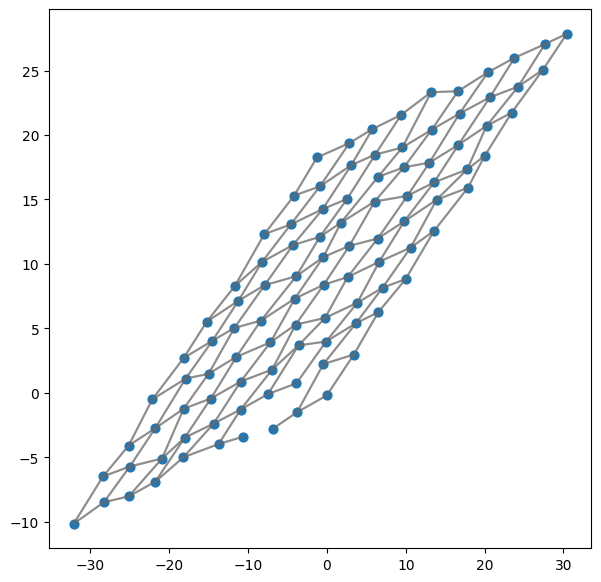

In [112]:
type_ = "oblique"
id_ = 10
graph = np.load(f"../GenData/{type_}/{type_}_{id_}.npz")
node_values = graph["nodes"]
edge_values = graph["edges"]
adj_list = graph["adj_list"]
pos = graph["positions"]
draw_graph(adj_list, pos, axis=True, node_size=40)

dat = graphToData(f"../GenData/{type_}/{type_}_{id_}.npz")
model.eval()
with torch.no_grad():
    dat = dat.to(device)
    pred = model(dat)
    print("predicition: ", pred)
    print("label: ", dat.y)